In [1]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import torch
import pickle
import torchvision
import time
import os

from models import VAE, ConvolutionalDRAW
from train import Train_Geco, Train_Beta, reconstruction_error, log_likelihood
from functions import sample_vae, marginal_KL, Compute_NLL
import datasets

In [2]:
torch.cuda.empty_cache() 

In [3]:
!nvidia-smi

Thu Mar  3 18:21:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.23       Driver Version: 511.23       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 27%   29C    P8    N/A /  75W |    513MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [5]:
def save_config(model, lambd_hist, train_hist, test_hist, path, model_name):
    if not os.path.exists(path):
        os.mkdir(path)
    hists = [lambd_hist, train_hist, test_hist]
    hists_name = ["lambd_hist", "train_hist", "test_hist"]
    for i, hist in enumerate(hists):
        a_file = open(path + "\\" + f"{hists_name[i]}.pkl", "wb")
        pickle.dump(hist, a_file)
        a_file.close()
    torch.save(model.state_dict(), path + "\\" + f"{model_name}.pt")

# Fashion MNIST

In [6]:
train_loader, test_loader, input_size, batch_size = datasets.get_dataset('FASHION_MNIST', batch_size=200)

## Geco with RE

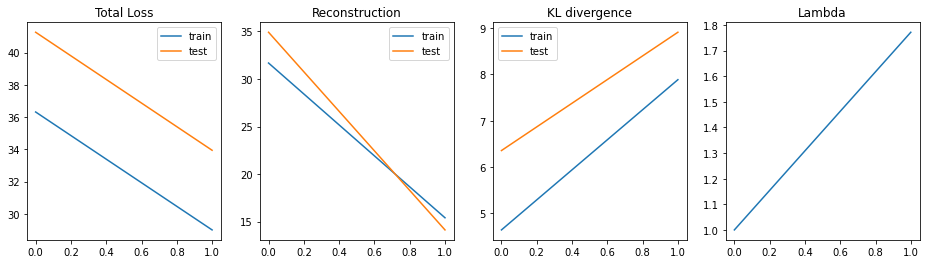

Epoch 2 of 2 took 10.252s
  training loss (in-iteration): 	28.998348
  validation loss (in-iteration): 	33.940596


In [7]:
vae_model_geco_re = VAE(dims = [28*28, 512, 256], dim_latent = 200)
optimizer = optim.Adam(vae_model_geco_re.parameters(), lr=1e-3)
scheduler = None
vae_train_geco_re = Train_Geco(model=vae_model_geco_re, optimizer=optimizer, scheduler=scheduler, train_loader=train_loader, 
                 test_loader=test_loader, init_lambda=torch.FloatTensor([1]), constraint_f=reconstruction_error, num_epochs=2,
                 lbd_step=50, alpha=0.99, verbose=True, device=device, tol=4, pretrain=0)

lambd_hist, train_hist, test_hist = vae_train_geco_re.train()

In [6]:
save_config(vae_model_geco_re, lambd_hist, train_hist, test_hist, f"models\\Draw_Geco_Fashion_RE", "vae_model_geco_re")

NameError: name 'vae_model_geco_re' is not defined

## Geco with NLL

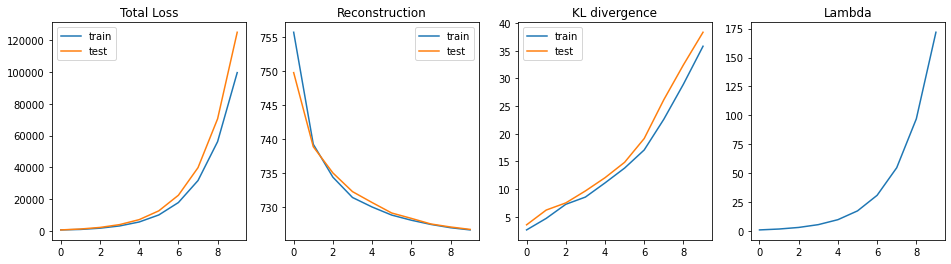

Epoch 10 of 20 took 9.047s
  training loss (in-iteration): 	99578.506354
  validation loss (in-iteration): 	124947.491406


KeyboardInterrupt: 

In [9]:
vae_model_geco_nll = VAE(dims = [28*28, 512, 256], dim_latent = 200, parametrized=True)
optimizer = optim.Adam(vae_model_geco_nll.parameters(), lr=1e-3)
scheduler = None
vae_train_geco_nll = Train_Geco(model=vae_model_geco_nll, optimizer=optimizer, scheduler=scheduler, train_loader=train_loader, 
                 test_loader=test_loader, init_lambda=torch.FloatTensor([1]), constraint_f=log_likelihood, num_epochs=20,
                 lbd_step=50, alpha=0.99, verbose=True, device=device, tol=4, pretrain=0)

lambd_hist, train_hist, test_hist = vae_train_geco_nll.train()

# Beta

## RE

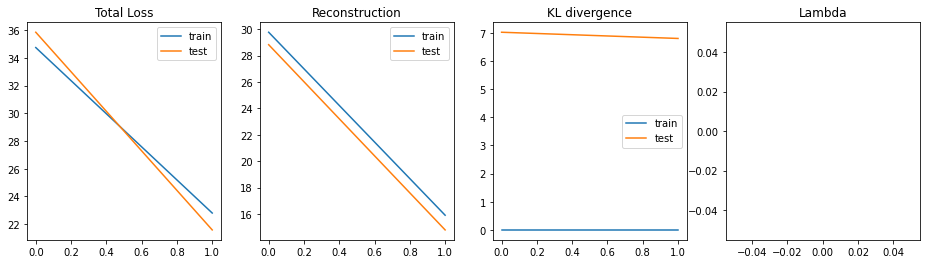

Epoch 2 of 2 took 10.207s
  training loss (in-iteration): 	22.804831
  validation loss (in-iteration): 	21.587223


ValueError: not enough values to unpack (expected 3, got 2)

In [7]:
vae_model = VAE(dims = [28*28, 512, 256], dim_latent = 200)
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
scheduler = None
vae_train_geco_re = Train_Beta(model=vae_model, optimizer=optimizer, scheduler=scheduler, train_loader=train_loader, 
                 test_loader=test_loader, constraint_f=reconstruction_error, num_epochs=2,
                 verbose=True, device=device, tol=4)

lambd_hist, train_hist = vae_train_geco_re.train()

## NLL

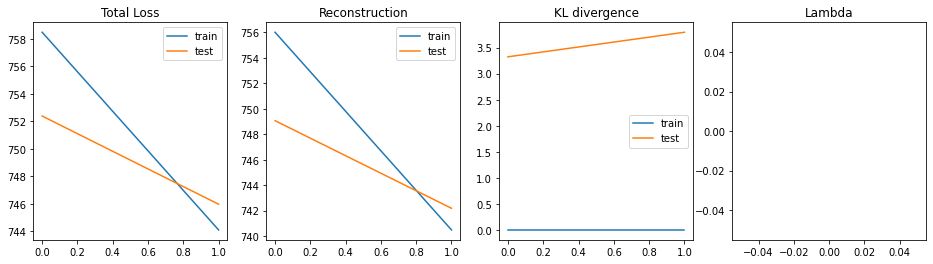

Epoch 2 of 2 took 8.884s
  training loss (in-iteration): 	744.114283
  validation loss (in-iteration): 	745.981305


In [8]:
vae_model = VAE(dims = [28*28, 512, 256], dim_latent = 200, parametrized=True)
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
scheduler = None
vae_train_geco_re = Train_Beta(model=vae_model, optimizer=optimizer, scheduler=scheduler, train_loader=train_loader, 
                 test_loader=test_loader, constraint_f=log_likelihood, num_epochs=2,
                 verbose=True, device=device, tol=4)

lambd_hist, train_hist = vae_train_geco_re.train()

# LFW

train_loader, test_loader, input_size, batch_size = datasets.get_dataset('LFW', batch_size=10)

## Geco

cd_model = ConvolutionalDRAW(x_dim = 3, x_shape = input_size, h_dim = 256, T = 1)
optimizer = optim.Adam(cd_model.parameters(), lr=1e-3)
scheduler = None

vae_train_geco = Train_Geco(model=cd_model, optimizer=optimizer, scheduler=scheduler, train_loader=train_loader, 
                 test_loader=test_loader, init_lambda=torch.FloatTensor([1]), num_epochs=50,
                 lbd_step=50, alpha=0.99, verbose=True, device=device, tol=0.6, pretrain=0)

lambd_hist, train_hist, test_hist = vae_train_geco.train()

vae_model_geco =  VAE(dims = [28*28, 512, 256], dim_latent = 200)

optimizer = optim.Adam(vae_model_geco.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)
scheduler = None
train_geco(vae_model_geco, optimizer, scheduler, 
           train_loader = train_loader, 
           valid_loader = test_loader, lbd_step = 1, 
           num_epochs=200,lambd_init = torch.FloatTensor([0.5]),
           tol = 4, visual=)

vae_model_geco =  VAE(dims = [28*28, 512, 256], dim_latent = 200)

def plot_gallery(images, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(3 * n_col, 1.9 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

cd_model = cd_model.cpu()
cd_model.eval()

img = next(iter(test_loader))[0]
plt.imshow(img.permute(1, 2, 0))

img_new = cd_model(torch.unsqueeze(img, 0))
img_new = img_new[0][0].permute(1, 2, 0).detach().numpy()
#print(img_new.shape)
plt.imshow(img_new)